# CIFAR10 Image Classification through Convolutional Neural Network using PyTorch

Author: Sahngyoon Rhee

In this project, we will use PyTorch to build a Convolutional Neural Network (CNN) model that classifies the CIFAR10 dataset.

You can learn more about the CIFAR10 dataset in [Alex Krizhevsky's webpage](https://www.cs.toronto.edu/~kriz/cifar.html).

In his own words: "The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each clas"

The ten possible classes for each image are as follows: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

The classes are mutually exclusive, meaning that (for example) an image cannot be classified as both an airplane or an automobile, or any other possible combinations. To put it in other words, there is only one correct label for each image.s.1010

## Concept of CNN - brief overview

A reader already familiar with CNN can skip this section.

The purpose of this project is not to go in-depth over the concepts of Convolutional Neural Networks, for which there are plenty of online resources. Instead, we shall focus on implementing CNN model for CIFAR10 image classification. In this introductory section, we briefly *review* the concepts of CNN.

A basic CNN consists of three types of layers: Convolutional layer, Pooling layer, and Fully Connected layer (here, we are skipping layers such as Batc Normalization, Dropout, etc.). A Convolutiona layer (henceforth denoted Conv layer) works by applying a filter (also called kernel) over our image, sliding the kernel over our image as we do dot product for each step. We can also adjust hyperparameters such as the kernel size, number of filters to be applied, stride (how much the filter moves at each step), padding, as well as other hyperparameters like the activation function, learning rate, and batch size.

Pooling layers are what allows us to reduce the spatial dimensions (height and width) of the feature maps generated by convolutional layers, while keeping the depth (ie.. the number of channels). This helps to decrease the number of things that the computer needs to keep track of, i.e. parameters, and also reduce the computations in the network, making it more efficient and less prone to overfitting. There are three types of pooling layers, max pooling, average pooling, and global pooling. The most commonly used pooling layer is the max pooling, and it helps in capturing the most significant features and provides better performance in many computer vision tasks (think about this and it'll make sense).

The fully connected layers, which typically comes after several iterations of the sequences of the following sequence (conv layer -> activation functions -> conv layer -> activation functions -> ... -> conv layer -> activation layer -> pooling layer ->), where we can have one or more (conv layer -> activation functions), is just a layer that you would typically see in a fully connected nueral network. After one or more fully conected layers, we then make an output - which, in our CIFAR10 image classification, will be a softmax layer.

## CNN - coding

We shall now jump into our coding. Thankfully, the CIFAR10 dataset is part of torchvision datasets.

In [1]:
# import necessary packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# device configuration - use cuda if you have one
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# set hyperparameters
num_epochs = 20
batch_size = 4
learning_rate = 1e-3

In [4]:
# dataset has PILImage images of range [0,1]
# We transform them into Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5),(.5, .5, .5))]
)
train_dataset = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = True
)

Files already downloaded and verified
Files already downloaded and verified


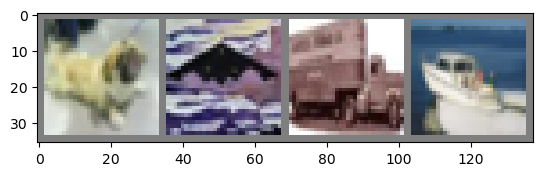

torch.Size([4, 3, 32, 32])


In [6]:
# define the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img * .5 + .5 # unnormalize the image
    npimg = img.numpy()
    # np.transpose(npimg, (1,2,0)) changes the order of the axes to (H, W, C) from the current (C, H, W)
    # Necessary since plt.imshow() expects the image data to be in the format (height, width, channels)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
conv2 = nn.Conv2d(6, 16, 5)
print(images.shape)
x = conv1(images)
x = pool(x)
x = conv2(x)
x = pool(x)

In [10]:
# implement the dataset
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # layers - in_channels are number of channels in the input image
        # out_channels are number of channels in the output image, i.e. the number of kernels we operate on the input image
        # kernel_size is the size of the kernel (e.g. 5 means 5 by 5)
        # the input image size is 32 by 32, so that using the formula (w - f + 2p)/s + 1 as the size of an output channel multiple times we get
        # 5*5 as the dimension of each channel right before the fc1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # the -1 in the following in the number of samples in our batch
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # notice that the last layer doesn't need a softmax activation since that's already included in nn.CrossEntropyLoss()
        return x        

# initialize the model
model = ConvNet().to(device)

# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# Get a batch of training data to print its shape
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Each train batch's shape: {images.size()}")

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # move data to GPU if we have it
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 2000 == 0 and epoch % 4 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i+1}/{n_total_steps}], loss: {loss.item():.4f}")

print("Training Finished")

# Evaluate the model
with torch.no_grad():
    n_correct, n_samples = 0, 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        # move test data to GPU if we have one
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # the `max` method returns (value, index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        # Count the total number of test images and the total number of correctly predicted images for each class
        # will be useful in getting recall for each class
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    acc = 100. * n_correct / n_samples
    print(f"Accuracy of the network: {acc} %")

    # Caluclate the accuracy for each class
    for i in range(10):
        acc = 100. * n_class_correct[i] / n_class_samples[i]
        print(f"Accuracy of {classes[i]}: {acc} %")

Each train batch's shape: torch.Size([4, 3, 32, 32])
Epoch [1/20], Step [2000/12500], loss: 2.2795
Epoch [1/20], Step [4000/12500], loss: 2.2911
Epoch [1/20], Step [6000/12500], loss: 2.3228
Epoch [1/20], Step [8000/12500], loss: 2.2472
Epoch [1/20], Step [10000/12500], loss: 2.3027
Epoch [1/20], Step [12000/12500], loss: 1.7526
Epoch [5/20], Step [2000/12500], loss: 1.3029
Epoch [5/20], Step [4000/12500], loss: 1.5510
Epoch [5/20], Step [6000/12500], loss: 1.6710
Epoch [5/20], Step [8000/12500], loss: 1.7683
Epoch [5/20], Step [10000/12500], loss: 1.5873
Epoch [5/20], Step [12000/12500], loss: 1.3690
Epoch [9/20], Step [2000/12500], loss: 0.9540
Epoch [9/20], Step [4000/12500], loss: 1.7814
Epoch [9/20], Step [6000/12500], loss: 1.4672
Epoch [9/20], Step [8000/12500], loss: 0.9750
Epoch [9/20], Step [10000/12500], loss: 0.7065
Epoch [9/20], Step [12000/12500], loss: 1.2505
Epoch [13/20], Step [2000/12500], loss: 0.5693
Epoch [13/20], Step [4000/12500], loss: 0.1578
Epoch [13/20], Step

In [11]:
# Uncomment and run the line below to save the parameters of the model
# torch.save(model.state_dict(), 'ConvNet_parameters.pth')
# Uncomment and run the line below to save the model
# torch.save(model, 'ConvNet.pth)